# Notebook 3: Solving the underlying transmission process

In this notebook we look at the underlying transmission process described in the main paper, and how this is solved in Julia. The underlying ODE is represented and solved using the DifferentialEquations.jl package, and familiarity with that package would be useful at this point. We cover:

* Loading underlying contact rate data, a low-dependency version of DifferentialEquations.jl, and KenyaSerology.
* Defining the transmission process as an ODE using the KenyaSerology package.
* Solving the ODE problem using the posterior mean parameter values for Nairobi and visualising the solution.

The underlying transmission dynamics in each county was represented as an ODE:
$$
    \dot{S}(t) = -{S(t)\over P_{eff} N} \gamma R_t I(t),\\ 
    \dot{E}(t) = {S(t)\over P_{eff} N} \gamma R_t I(t) - \sigma E(t),\\
    \dot{I}(t) = \sigma E(t) - \gamma I(t),\\
    \dot{R}(t) = \gamma I(t),\\
    \dot{C}(t) = {S(t)\over P_{eff} N} \gamma R_t I(t).
$$
Where $1/\sigma = 3.1$ days was the mean time between infection and infectiousness, and $1/\gamma = 2.4$ days was chosen as the mean infectious period to match a 5.5 day serial interval. The system is a standard SEIR model with one exception: an *effective* population size of less than $N$ due to the effect of heterogeneity in the underlying population (also $S(0) = P_{eff} N - E(0) - I(0)$). The dynamic variable $C(t)$ tracks cumulative infections. $R_t = R_0 m(t)$ where $m(t)$ is the mobility rate and $R_0$ is a baseline reproductive number.

As in notebook 2 we load a low-dependency version of DifferentialEquations.jl called `OrdinaryDiffEq`. `OrdinaryDiffEq` gives us access to types to represent ode problems and solutions as well as solvers. Rather than define the ODE problems directly, although if that is your inclination we highly recommend investigating and trying out the [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) package, we use a method for building the ODE problem defined in the `KenyaSerology` module.

In [7]:
cd(joinpath(homedir(),"GitHub/KenyaSerology/")) #Sets the working directory to the /KenyaSerology directory
push!(LOAD_PATH, joinpath(homedir(),"GitHub/KenyaSerology/src")) #Adds the source code directory for KenyaSerology to the LOAD_PATH global variable

using JLD2,Plots,Dates
using OrdinaryDiffEq #A low dependency version of DifferentialEquations.jl which introduces only ODE solvers
import KenyaSerology #Imports the KenyaSerology package

@load("data/projected_contact_data_10082020.jld2")

3-element Array{Symbol,1}:
 :projected_contactrate_nairobi
 :projected_contactrate_mombasa
 :projected_contactrate_kenya  

The `@load("data/projected_contact_data_10082020.jld2")` line loaded the three `NamedTuples` into scope that we generated in Notebook 1. Now we use a method from the KenyaSerology package to create an `ODEProblem` object (this contains everything required to solve the transmission process). At the moment the method only works for a start date of 21st Feb 2020, because of how the underlying contact rate data is interpreted, we will be making the method more flexible in future developments.

In [8]:
transmission_prob = KenyaSerology.make_odeproblemforinference(projected_contactrate_nairobi,#Method for defining the ODE problem underlying the inference
                                                                                        startdate = Date(2020,2,21),#Don't change from Feb 21st as start date!
                                                                                        enddate = Date(2020,10,1)) #Solve until 1st October

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 223.0)
u0: [4.3e6, 100.0, 100.0, 0.0, 0.0]

The `ODEProblem` called `transmission_prob` is defined with placeholder parameters and initial conditions. These are exactly the underlying unknowns that we aimed to get an insight into in the main paper. To skip ahead, we will use posterior mean estimates for the underlying unknowns for Nairobi (the Kenyan capital city) which are recorded in `opendatacsvs/DataS1.csv`, and then solve the ODEProblem using the Bogacki-Shampine 3/2 method.

In [27]:
#First define the parameter estimates (using values for Nairobi from opendatacsvs/DataS1.csv)
R̂ = 2.01
Ê₀ = 40.4
Î₀ = 2.56
P̂_eff = 0.77
N = 4.3e6
σ = 1/3.1
γ = 1/2.4

transmission_sol = solve(transmission_prob,BS3(), #This function creates an ODESolution from the underlying problem using the BS3 solver
                            p = [R̂,σ,γ,P̂_eff*N], #This keyword argument redefines the ODE parameters before solution
                            u0 = [(P̂_eff*N)-Ê₀-Î₀,Ê₀,Î₀,0.,0.]); #This keyword argument redefines the ODE initial conditions before solution


Having solved the ODE problem we would like to visualise the solution. We do this using the `plot` method for `ODESolution` objects, with the additional of a "total S" variable which accounted for the extra susceptibles predicted by the effective population size model.

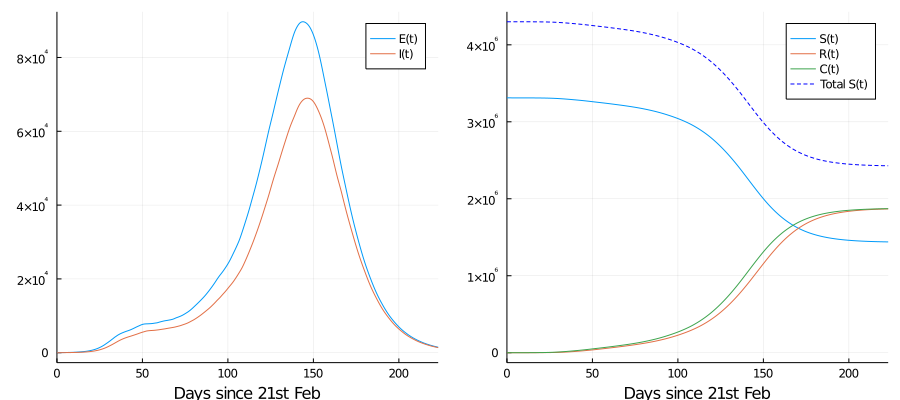

In [33]:
plt1 = plot(transmission_sol,xlabel = "Days since 21st Feb",vars = [2,3])
plt2 = plot(transmission_sol,xlabel = "Days since 21st Feb",vars = [1,4,5])

S_total = [u[1] + (1-P̂_eff)*N for u in transmission_sol.u]
plot!(plt2,transmission_sol.t,S_total,ls = :dash,color = :blue,label = "Total S(t)")

plot(plt1,plt2,
    size = (900,400))

We can see in the left hand plot that we are estimating that around day 50 (11th April) transmission was almost turned over in Nairobi (prevalence is flat in that period), however, prevalence rebounds after about day 70 (1st May). We are also estimating that the peak in prevalence (which is not the same as peak in detection) occurred before day 150 (20th July).